In [2]:
pip install nltk matplotlib seaborn wordcloud

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Student\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Enter CSV file path:  C:\Users\Student\Downloads\test.csv


UTF-8 decoding failed. Trying latin1 encoding...
Columns in dataset: ['textID', 'text', 'sentiment', 'Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)']
Text columns detected: ['textID', 'text', 'sentiment', 'Time of Tweet', 'Age of User', 'Country']
Analyzing sentiment for column: 'textID'
Analyzing sentiment for column: 'text'
Analyzing sentiment for column: 'sentiment'
Analyzing sentiment for column: 'Time of Tweet'
Analyzing sentiment for column: 'Age of User'
Analyzing sentiment for column: 'Country'

Combined Sentiment Counts Across All Text Columns:
Positive     2844
Neutral     16465
Negative     1895
Name: count, dtype: int64


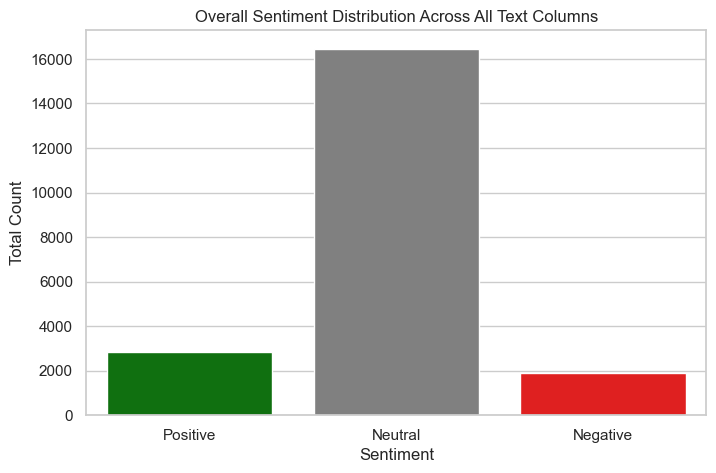

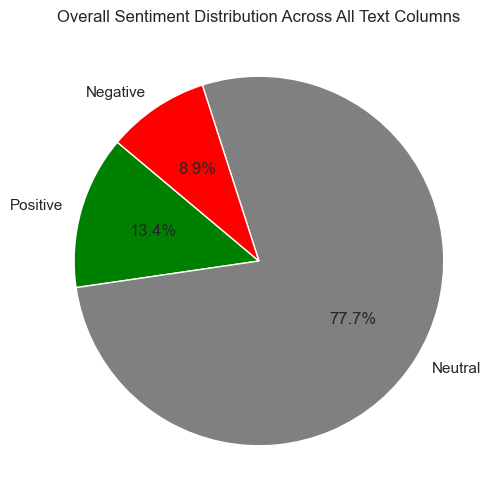

In [ ]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('vader_lexicon')

def analyze_sentiment_on_column(df, col):
    sia = SentimentIntensityAnalyzer()
    def analyze_text(text):
        score = sia.polarity_scores(str(text))
        compound = score['compound']
        if compound >= 0.05:
            sentiment = 'Positive'
        elif compound <= -0.05:
            sentiment = 'Negative'
        else:
            sentiment = 'Neutral'
        return pd.Series([compound, sentiment])

    results = df[col].apply(analyze_text)
    results.columns = [f"{col}_SentimentScore", f"{col}_Sentiment"]
    return results

# === Usage ===
path = input("Enter CSV file path: ").strip()

try:
    df = pd.read_csv(path, encoding='utf-8')
except UnicodeDecodeError:
    print("UTF-8 decoding failed. Trying latin1 encoding...")
    df = pd.read_csv(path, encoding='latin1')

print("Columns in dataset:", list(df.columns))

# Detect all text columns
text_columns = df.select_dtypes(include=['object']).columns.tolist()

if not text_columns:
    print("No text columns found in dataset.")
else:
    print(f"Text columns detected: {text_columns}")

    all_sentiments = []

    # Analyze sentiment per text column and store sentiment labels in a list
    for col in text_columns:
        print(f"Analyzing sentiment for column: '{col}'")
        temp_df = df.dropna(subset=[col])
        results = analyze_sentiment_on_column(temp_df, col)

        # Add sentiment columns back to main df (optional)
        df.loc[temp_df.index, f"{col}_SentimentScore"] = results[f"{col}_SentimentScore"]
        df.loc[temp_df.index, f"{col}_Sentiment"] = results[f"{col}_Sentiment"]

        # Append sentiments for aggregation
        all_sentiments.extend(results[f"{col}_Sentiment"].tolist())

    # Create a DataFrame of combined sentiments across all text columns
    combined_sentiment_series = pd.Series(all_sentiments)

    # Aggregate sentiment counts
    sentiment_counts = combined_sentiment_series.value_counts().reindex(['Positive', 'Neutral', 'Negative'], fill_value=0)

    print("\nCombined Sentiment Counts Across All Text Columns:")
    print(sentiment_counts)

    # Plot combined sentiment distribution - bar chart
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette={'Positive':'green', 'Negative':'red', 'Neutral':'gray'})
    plt.title('Overall Sentiment Distribution Across All Text Columns')
    plt.xlabel('Sentiment')
    plt.ylabel('Total Count')
    plt.show()

    # Plot combined sentiment distribution - pie chart
    plt.figure(figsize=(6,6))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%',
            colors=['green', 'gray', 'red'], startangle=140)
    plt.title('Overall Sentiment Distribution Across All Text Columns')
    plt.show()

    # Optionally save full dataframe with sentiment columns
    save_choice = input("\nDo you want to save the dataset with sentiment columns? (y/n): ").strip().lower()
    if save_choice == 'y':
        output_path = input("Enter output CSV file path: ").strip()
        df.to_csv(output_path, index=False)
        print(f"Results saved to {output_path}")
